Dataset from:  
"Liar, Liar Pants on Fire":
The New Benchmark Dataset for Fake News Detection

LINK: https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

2019-03-02

In [ ]:
import os
import zipfile
import pandas as pd
import shutil
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = 'drive/MyDrive/Colab Notebooks/data_mining'
filename = 'liar_dataset.zip'

# Define file paths
zip_path = os.path.join(base_dir, filename)
extract_path = os.path.join(base_dir, "liar_dataset")

# Step 2: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: drive/MyDrive/Colab Notebooks/data_mining/liar_dataset


In [ ]:
# Load training, validation, and test datasets into DataFrames
train_path = os.path.join(extract_path, "train.tsv")
valid_path = os.path.join(extract_path, "valid.tsv")
test_path = os.path.join(extract_path, "test.tsv")

# Define column names based on the dataset structure
columns = [
    "id", "label", "statement", "subject", "speaker", "job",
    "state", "party", "barely_true", "false",
    "half_true", "mostly_true", "pants_on_fire", "context"
]

# Load datasets
train_df = pd.read_csv(train_path, sep='\t', header=None, names=columns)
valid_df = pd.read_csv(valid_path, sep='\t', header=None, names=columns)
test_df = pd.read_csv(test_path, sep='\t', header=None, names=columns)

print("Datasets loaded successfully!")

Datasets loaded successfully!


In [ ]:
# Check the shape of the datasets
print(f"Train Dataset: {train_df.shape}")
print(f"Validation Dataset: {valid_df.shape}")
print(f"Test Dataset: {test_df.shape}")

# Display the first few rows of the training dataset
print("Sample rows from the training dataset:")
print(train_df.head())

# Check for missing values
print("\nMissing values in the training dataset:")
print(train_df.isnull().sum())

# Analyze label distribution
print("\nLabel distribution in the training dataset:")
print(train_df["label"].value_counts())


Train Dataset: (10240, 14)
Validation Dataset: (1284, 14)
Test Dataset: (1267, 14)
Sample rows from the training dataset:
           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker                   job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN

In [ ]:
base_dir

'drive/MyDrive/Colab Notebooks/data_mining'

Plot distribution of data by label

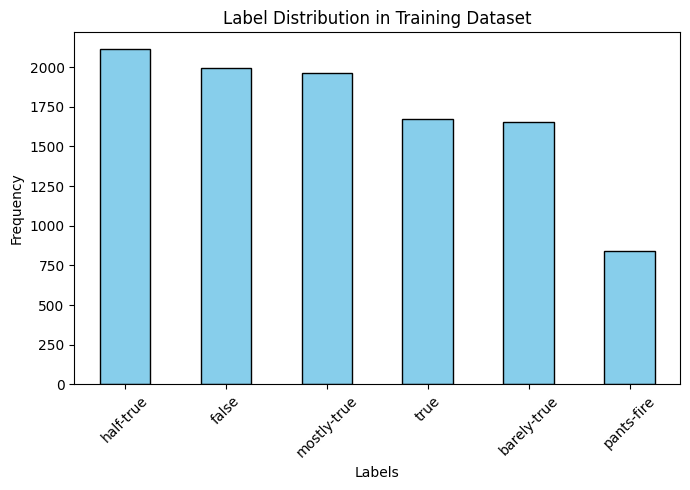

In [ ]:
# Plot label distribution
label_counts = train_df["label"].value_counts()
plt.figure(figsize=(7, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Label Distribution in Training Dataset")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "images", "class_distribution.png"), bbox_inches='tight')
plt.show()

### Data Cleaning:

As far as metadata is concerned, `speaker`, `party` and `subject` columns are mostly populated except for two (2) rows with nulls.

For baseline, I will use `speaker` and `party` as metadata fields to be used in addition to the `statement` text as input for modeling.

In [ ]:
# Drop rows with missing "speaker" and "party".
train_df.dropna(subset=["speaker", "party"], inplace=True)
valid_df.dropna(subset=["speaker", "party"], inplace=True)
test_df.dropna(subset=["speaker", "party"], inplace=True)

Number of unique speaker values:  2910


<ipython-input-28-07cae0a426b9>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="viridis")


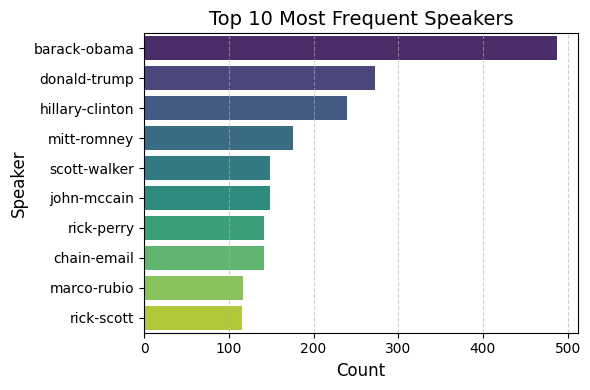

In [ ]:
# Visualize count for different speaker values

print("Number of unique speaker values: ",train_df['speaker'].nunique())

# Get top 10 speakers
top_speakers = train_df['speaker'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="viridis")
plt.xlabel("Count", fontsize=12)
plt.ylabel("Speaker", fontsize=12)
plt.title("Top 10 Most Frequent Speakers", fontsize=14)
plt.grid(axis='x', linestyle="--", alpha=0.6)  # Light grid for better readability
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "images", "top10_speakers.png"), bbox_inches='tight')
# Show the plot
plt.show()


Total number of unique values for party:  23


<ipython-input-27-88b799dd250b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=party_counts.values, y=party_counts.index, palette="viridis")


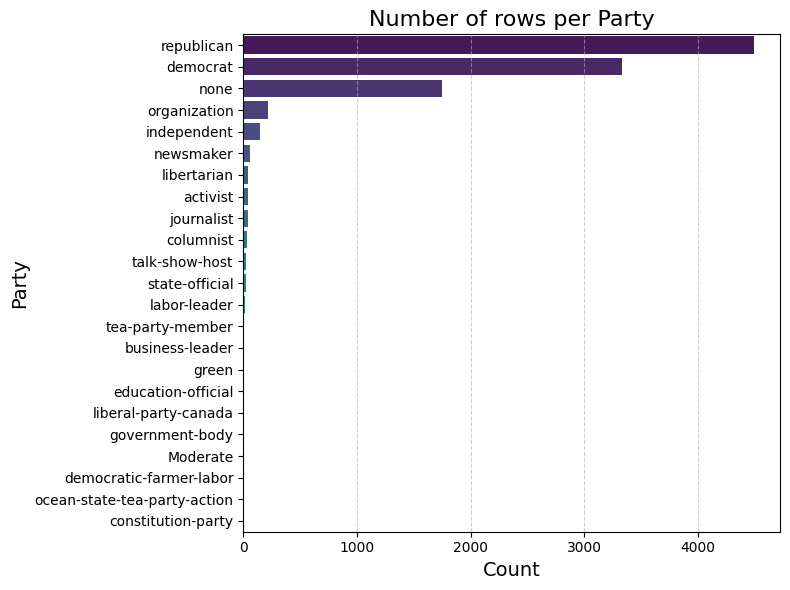

In [ ]:
# Visualize counts per party

print("Total number of unique values for party: ", train_df['party'].nunique())

# Get counts for party
party_counts = train_df['party'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))  # Increase the width and height
sns.barplot(x=party_counts.values, y=party_counts.index, palette="viridis")
plt.xlabel("Count", fontsize=14)
plt.ylabel("Party", fontsize=14)
plt.title("Number of rows per Party", fontsize=16)
plt.grid(axis='x', linestyle="--", alpha=0.6)

plt.tight_layout()  # Adjust layout to prevent truncation
plt.savefig(os.path.join(base_dir, "images", "count_per_party.png"), bbox_inches='tight')  # Prevents cropping
plt.show()

### Text preprocessing for EDA

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader
import regex as re
import string
import torch
from torch import nn

# Preprocess sentences

def process_tweet_tokens(tweet):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    tweet = tweet.lower()
    # remove ellipsis (three or more dots)
    tweet = re.sub(r'\.{2,}', '', tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags (only removing the hash # sign from the word)
    tweet = re.sub(r'#', '', tweet)

    tokens = word_tokenize(tweet)
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

def process_sentences(sentences):
    processed_sentences = []

    for sentence in sentences:
        tokens = process_tweet_tokens(sentence)
        processed_sentences.append(' '.join(tokens))

    return processed_sentences

def preprocess(sent_tokens):
    word_to_idx = {word: i+1 for i, word in enumerate(sent_tokens)}
    word_to_idx['<UNK>'] = 0
    return [word_to_idx.get(w.lower(), word_to_idx['<UNK>']) for w in sent_tokens]



# Dataset class
class TextDataset(Dataset):
    def __init__(self, text):
        self.text = text

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return self.text[idx]

# Encode sentences
def encode_sentences(sentences):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(sentences)
    encoded_sentences = X.toarray()
    return encoded_sentences, vectorizer

# Extract sentences from text
def extract_sentences(data):
    sentences = re.findall(r'[A-Z][^.!?]*[.!?]', data)
    return sentences

# Text processing pipeline
def text_processing_pipeline(text):
    sentences = extract_sentences(text)
    processed_sentences = process_sentences(sentences)
    encoded_sentences, vectorizer = encode_sentences(processed_sentences)
    dataset = TextDataset(encoded_sentences)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
    return dataloader, vectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_df.head(5)

,id,label,statement,subject,speaker,job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

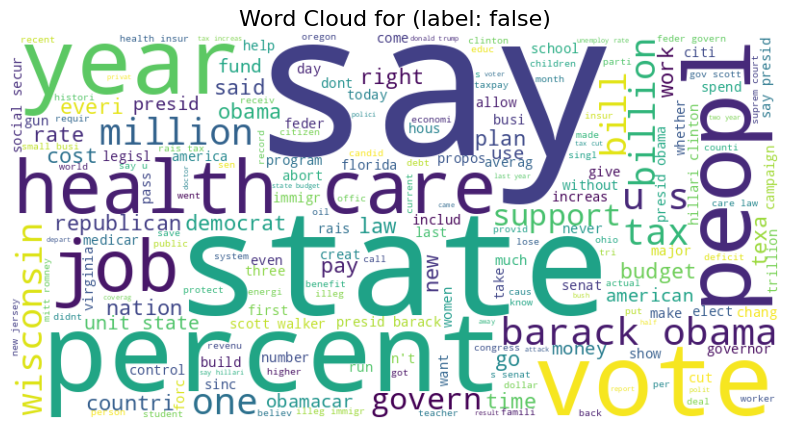

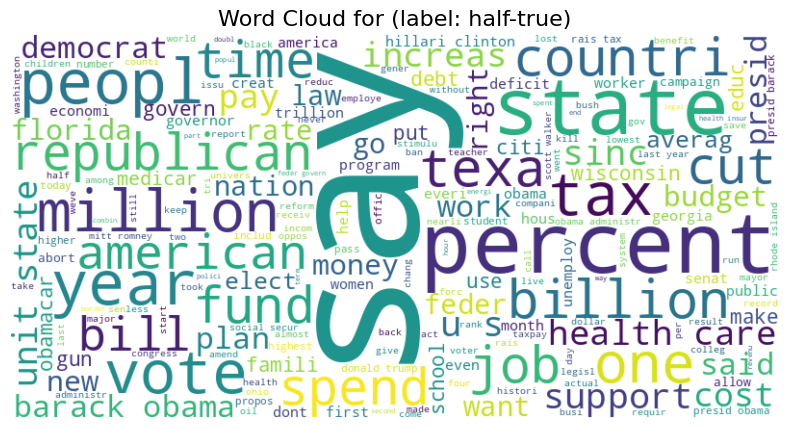

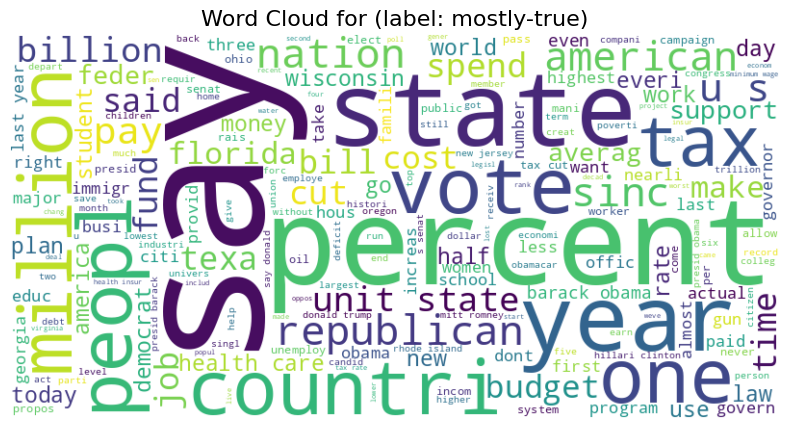

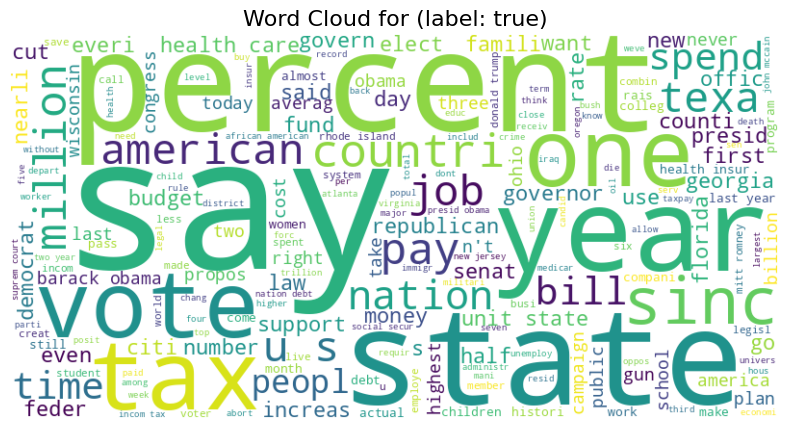

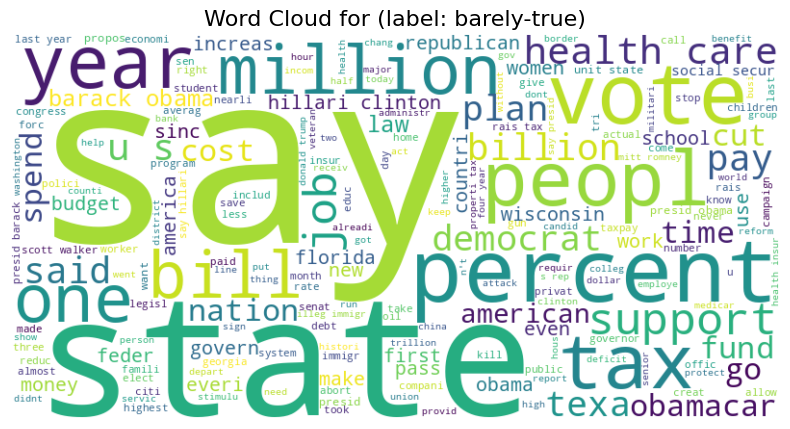

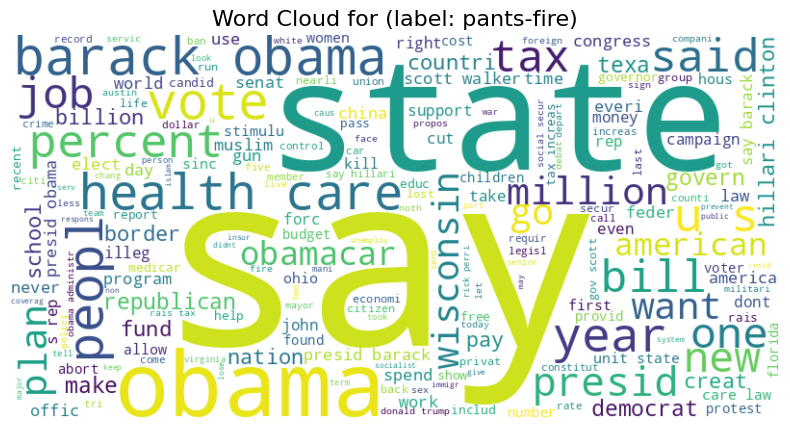

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate WordCloud for a specific class
def generate_wordcloud(text, title, filename=""):
    wordcloud = WordCloud(
        width=800, height=400, background_color='white'
    ).generate(' '.join(text))

    # Display the wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.savefig(os.path.join(base_dir, "images", f"{filename}.png"))
    plt.show()

# Separate texts by class
def display_wordclouds_by_class(df, text_column='statement', target_column='label'):

    labels = df[target_column].unique()
    for label in labels:
    # Process tweets for class 0
      class_text = df[df[target_column] == label][text_column].apply(process_tweet_tokens).apply(' '.join)
      generate_wordcloud(class_text, title=f'Word Cloud for (label: {label})', filename=label)



# Example usage with train_df
display_wordclouds_by_class(train_df)

In [ ]:
train_df.context.head(10)

,context
0,a mailer
1,a floor speech.
2,Denver
3,a news release
4,an interview on CNN
5,a an online opinion-piece
6,a press release.
7,"a Democratic debate in Philadelphia, Pa."
8,a website
9,an online video


### Text Pre-processing for Modeling:
Huggingface's `AutoTokenizer` will be used.
- `AutoTokenizer` is used when working with pre-trained transformer models like BERT, GPT, T5, etc.
- stopword removal will not be necessary in this step, because Transformer models like BERT, GPT, and T5 are trained with stopwords include, so removing them could hurt model performance.
- Transformers rely on contextual embeddings, which means even stopwords can carry meaning.

In [ ]:
# ! pip install datasets

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from transformers import AutoTokenizer
from datasets import Dataset

In [ ]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset as TorchDataset
from datasets import Dataset
from sklearn.preprocessing import OneHotEncoder

# Map labels to numerical values
label_map = {"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, "mostly-true": 4, "true": 5}
train_df["label"] = train_df["label"].map(label_map)
valid_df["label"] = valid_df["label"].map(label_map)
test_df["label"] = test_df["label"].map(label_map)

# One-hot encode 'speaker' and 'party' (Fit on train, Transform on valid and test)
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

train_metadata = encoder.fit_transform(train_df[["speaker", "party"]])
valid_metadata = encoder.transform(valid_df[["speaker", "party"]])
test_metadata = encoder.transform(test_df[["speaker", "party"]])

# Load tokenizer for BERT/RoBERTa
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_text(text):
    """Tokenizes input text and returns input_ids and attention_mask."""
    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    return encodings["input_ids"].squeeze(0), encodings["attention_mask"].squeeze(0)

# Apply tokenization to each dataset
train_tokenized = train_df["statement"].apply(tokenize_text)
valid_tokenized = valid_df["statement"].apply(tokenize_text)
test_tokenized = test_df["statement"].apply(tokenize_text)

# Extract input_ids and attention_mask separately
train_df["input_ids"], train_df["attention_mask"] = zip(*train_tokenized)
valid_df["input_ids"], valid_df["attention_mask"] = zip(*valid_tokenized)
test_df["input_ids"], test_df["attention_mask"] = zip(*test_tokenized)

# Convert metadata to list format
train_metadata = train_metadata.tolist()
valid_metadata = valid_metadata.tolist()
test_metadata = test_metadata.tolist()

# Extract labels
train_labels = train_df["label"].tolist()
valid_labels = valid_df["label"].tolist()
test_labels = test_df["label"].tolist()

# Create dataset dictionaries
train_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(train_df["input_ids"], train_df["attention_mask"], train_metadata, train_labels)]

valid_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(valid_df["input_ids"], valid_df["attention_mask"], valid_metadata, valid_labels)]

test_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
             for text, mask, meta, label in zip(test_df["input_ids"], test_df["attention_mask"], test_metadata, test_labels)]

# Convert to Hugging Face dataset format
train_dataset = Dataset.from_list(train_data)
valid_dataset = Dataset.from_list(valid_data)
test_dataset = Dataset.from_list(test_data)

print("Data Preprocessing Complete")

# Convert Hugging Face dataset to PyTorch Dataset for Dataloader
class LIARDataset(TorchDataset):
    def __init__(self, hf_dataset, use_metadata=False):
        self.dataset = hf_dataset
        self.use_metadata = use_metadata  # Control whether metadata is used

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        data_dict = {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(item["label"], dtype=torch.long),
        }

        if self.use_metadata:
            data_dict["metadata"] = torch.tensor(item["metadata"], dtype=torch.float)

        return data_dict

# Create DataLoader for test set
test_torch_dataset = LIARDataset(test_dataset, use_metadata=False)  # Set to True if metadata is needed
test_dataloader = DataLoader(test_torch_dataset, batch_size=16, shuffle=False)

print("Test DataLoader Ready")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Data Preprocessing Complete
Test DataLoader Ready


## Model 1:

Train `BERT` and `RoBERTa` for Fake News Classification, this will be just using the text in the `statement` column as input.

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

trainer.train()

print("BERT Model Training Complete")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: ayesha-mendoza (ayesha-mendoza-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,1.722800,1.764413
2,1.581800,1.700122
3,1.218500,1.940533


BERT Model Training Complete


### Save pre-trained BERT model:
```
bert_model/
  ├── config.json
  ├── model.safetensors
  ├── tokenizer.json  ✅ (Required for loading!)
  ├── tokenizer_config.json  ✅
  ├── vocab.txt  ✅ (for BERT-based tokenizers)
  ```

In [ ]:
model_path = os.path.join(base_dir, "bert_model")
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"BERT model saved to: {model_path}")


BERT model saved to: drive/MyDrive/Colab Notebooks/data_mining/bert_model


In [ ]:
# test loading of saved model
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the saved model
bert_model = AutoModelForSequenceClassification.from_pretrained(model_path)
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)

print("Model loaded successfully!")


✅ Model loaded successfully!


## RoBERTa Model Training

In [ ]:
training_args.learning_rate

5e-05

In [ ]:
# Load pre-trained RoBERTa model
roberta_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=6)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Increase epochs
    weight_decay=0.01,
    learning_rate=2e-5,  # Reduce learning rate for better stability
    logging_dir="./logs",
)

trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

trainer.train()

print("✅ RoBERTa Model Training Complete")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
roberta_path = os.path.join(base_dir, "roberta_model")
roberta_model.save_pretrained(roberta_path)
tokenizer.save_pretrained(roberta_path)

print(f"RoBERTa model saved to: {roberta_path}")

# Load the saved model
# roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_path)
# roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_path)

# print("✅ Model loaded successfully!")


RoBERTa model saved to: drive/MyDrive/Colab Notebooks/data_mining/roberta_model


## Evaluate BERT and RoBERTa models.

In [ ]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def evaluate_model(model, dataloader, device, num_classes=6):
    model.to(device)
    model.eval()

    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)

            # Debug
            print("Sample Logits:", outputs.logits[:5])
            break


            # Move tensors back to CPU
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities for AUC

    # Compute accuracy, precision, recall, and F1
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

    # One-hot encode labels for multi-class AUC
    all_labels_one_hot = label_binarize(all_labels, classes=np.arange(num_classes))

    try:
        auc_roc = roc_auc_score(all_labels_one_hot, all_probs, multi_class="ovo")
    except ValueError:
        auc_roc = float("nan")  # Handle case where only one class is predicted

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    return accuracy, precision, recall, f1, auc_roc, all_preds, all_labels, all_probs




In [ ]:
# Evaluate BERT and RoBERTa models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_results = evaluate_model(bert_model, test_dataloader, device)
roberta_results = evaluate_model(roberta_model, test_dataloader, device)


Accuracy: 0.2715
Precision: 0.2751, Recall: 0.2715, F1-Score: 0.2642
AUC-ROC: 0.6409
Accuracy: 0.2092
Precision: 0.0437, Recall: 0.2092, F1-Score: 0.0724
AUC-ROC: 0.4956


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


end evaluate

In [ ]:
bert_results[5][:10]

[1, 2, 1, 2, 2, 4, 4, 2, 5, 3]

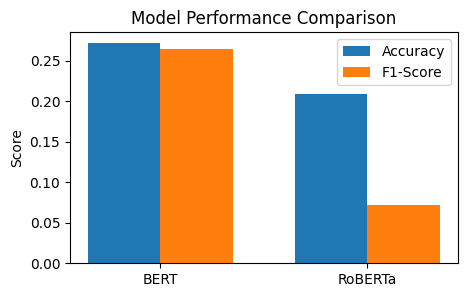

In [ ]:
import numpy as np

models = ["BERT", "RoBERTa"] #, "Hybrid"]
accuracy_scores = [bert_results[0], roberta_results[0]]
f1_scores = [bert_results[3], roberta_results[3]]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(x - width/2, accuracy_scores, width, label="Accuracy")
ax.bar(x + width/2, f1_scores, width, label="F1-Score")

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.legend()

plt.show()


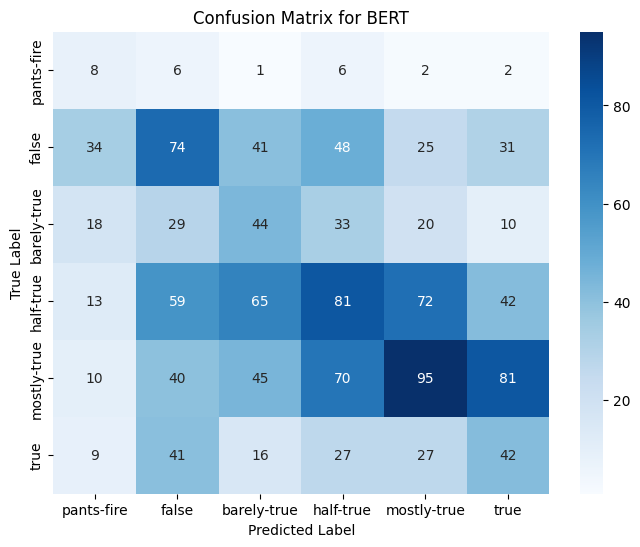

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(bert_results[5], bert_results[6], title="Confusion Matrix for BERT")


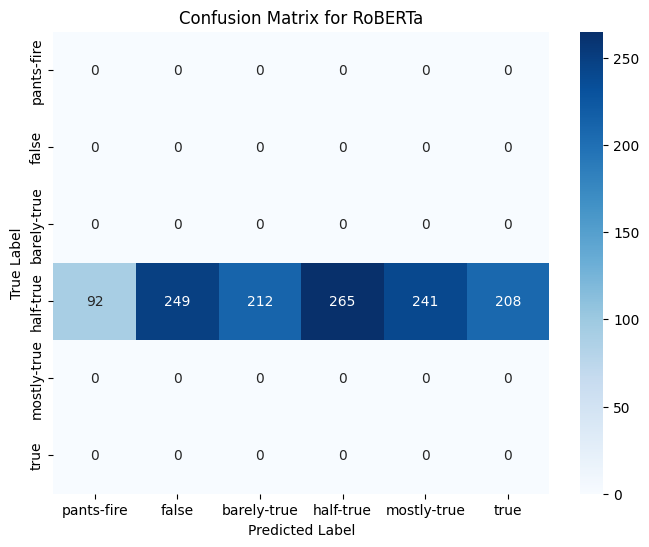

In [ ]:
plot_confusion_matrix(roberta_results[5], roberta_results[6], title="Confusion Matrix for RoBERTa")

In [ ]:
_ = evaluate_model(roberta_model, test_dataloader, device)

Sample Logits: tensor([[-0.7537,  0.1947, -0.0397,  0.2273,  0.1939,  0.0277],
        [-0.7537,  0.1947, -0.0397,  0.2273,  0.1939,  0.0277],
        [-0.7537,  0.1947, -0.0397,  0.2273,  0.1939,  0.0277],
        [-0.7537,  0.1947, -0.0397,  0.2273,  0.1939,  0.0277],
        [-0.7537,  0.1947, -0.0397,  0.2273,  0.1939,  0.0277]],
       device='cuda:0')


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: y has 0 samples: []

In [ ]:
# accuracy, precision, recall, f1, auc_roc, all_preds, all_labels, all_probs
roberta_results[5][:20]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [ ]:
roberta_results[6][:20]

[5, 1, 1, 3, 0, 5, 5, 2, 5, 2, 2, 2, 0, 1, 3, 5, 0, 3, 5, 1]

In [ ]:
roberta_results[7][:20]

[array([0.07659996, 0.19774804, 0.15642518, 0.20430645, 0.19758402,
        0.16733634], dtype=float32),
 array([0.07659987, 0.19774875, 0.1564252 , 0.20430647, 0.19758397,
        0.16733576], dtype=float32),
 array([0.07659921, 0.19774835, 0.15642616, 0.20430452, 0.1975852 ,
        0.1673365 ], dtype=float32),
 array([0.07659934, 0.19774865, 0.15642579, 0.20430581, 0.19758442,
        0.16733602], dtype=float32),
 array([0.07659994, 0.19774784, 0.15642513, 0.20430718, 0.1975835 ,
        0.16733651], dtype=float32),
 array([0.07659996, 0.1977482 , 0.15642495, 0.20430715, 0.19758378,
        0.167336  ], dtype=float32),
 array([0.0765999 , 0.19774799, 0.15642485, 0.20430751, 0.19758366,
        0.16733608], dtype=float32),
 array([0.07659943, 0.19774827, 0.15642548, 0.20430633, 0.19758452,
        0.167336  ], dtype=float32),
 array([0.07659961, 0.19774847, 0.15642557, 0.20430493, 0.19758484,
        0.16733658], dtype=float32),
 array([0.07659988, 0.19774821, 0.15642482, 0.20430745,